In [1]:
import numpy as np
from matplotlib import pyplot as plt

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls ./drive/MyDrive/Y2021/ANN/w13App

ANN_aux.py  code  data	__pycache__


In [5]:
import sys
sys.path.append("./drive/MyDrive/Y2021/ANN/w13App") # my path

from ANN_aux import *

def identity(a):
    return a

def mlp2(c, v, b, w, X, oact=identity):

    a = b.T + np.dot(X, w.T)            # a: array N x M
    z = sigmoid(a)                      # z: array N x M

    a2 = c.T + np.dot(z, v.T)           # a2: array N x K
    yhat = oact(a2)                     # yhat: array N x K

    return yhat

def mse_loss(x, y, yp):

    return np.mean((yp - y)**2)

def train_mlp2(c, v, b, w, X, Y, lr1, lr2, nepochs, 
               oact=identity, loss=mse_loss, disp=False, 
               val=None, val_criteria=1):

  N, D = X.shape

  losses = []

  # For early stopping
  
  best_val_loss = np.inf
  best_params = (c, v, b, w)
  val_count = 0


  # Learning
  for i in range(nepochs):

      # Forward pass
      a = b.T + np.dot(X, w.T)            # a: array N x M
      z = sigmoid(a)                      # z: array N x M
      a2 = c.T + np.dot(z, v.T)           # a2: array N x K
      z2 = oact(a2)                       # z2: array N x K
      yhat = z2                           # yhat: array N x K

      # Backward pass
      delta2 = yhat - Y                   # delta2: array N x K
      OneVec = np.ones(N).reshape((1,-1)) # OneVec: array 1 x N
      dLc = np.dot( OneVec, delta2 ).T    # dLc: array K x 1
      dLv = np.dot( z.T, delta2 ).T       # dLv: array K x M
      H = np.multiply(1 - z, z)           # H: array N x M
      delta1 = np.dot(delta2, v) * H      # delta1: array N x M
      dLb = np.dot( OneVec, delta1 ).T    # dLb: array M x 1
      dLw = np.dot( X.T, delta1 ).T       # dLw: array M x D

      lossi = loss(X, Y, yhat)
      
      if np.isnan(lossi):  
          print('Reach NaN. Terminated.')
          break

      losses.append(lossi)

      c -= dLc * lr2
      v -= dLv * lr2
      b -= dLb * lr1
      w -= dLw * lr1

      if disp:
        if i % 5000 == 0:
            print('mse = %.4f' % mse)

      if val is not None:
        # Do early stopping
        # Here, we use a simple strategy: no best saving and one worse out.

        # (1) Check validate set
        valx, valy = val
        valyp = mlp2(c, v, b, w, valx, oact)

        val_loss = loss(valx, valy, valyp)
        print(i, '* val loss=', val_loss)

        if val_loss < best_val_loss:
          best_val_loss = val_loss
          best_params = (c, v, b, w)
          val_count = 0

        elif val_loss > best_val_loss:
          val_count += 1

          if val_count >= val_criteria:
            print('Early stopping criteria is met at', i)
            c, v, b, w = best_params
            break
          # enf if val_criteria
        # enf if val_loss
      # end if val

  # end for i

  return c, v, b, w, losses


def cross_entropy(x, y, yp):
    
    return np.sum(-np.log(yp[y == 1]))+np.sum(-np.log(1-yp[y == 0]))


def onehot(y, classes=None):
  '''
  input y: N x 1
  classes: unique values of y, e.g., [0, 1, 2]
  output yhot: N x K
  '''

  if classes is None:
    classes = np.unique(y)

  K = len(classes)
  N = y.shape[0]
  codebook = np.diag(np.ones(K))

  yhot = codebook[y[:,0]]

  return yhot


def softmax(a):
  '''
  a: N x K
  '''
  amax = np.max(a, axis=1, keepdims=True)
  
  ea = np.exp(a - amax)

  s = np.sum(ea, axis=1, keepdims=True)
  z = ea/s
  return z

def cc_entropy(x, yonehot, yp, eps=1e-323, do_sum=True):
    '''
    yonehot: N x K  (in one-hot coding)
    yp: N x K
    '''
    Ln = -np.log(np.sum(yonehot * yp, axis=1, keepdims=True) + eps)

    if do_sum:
      return np.sum(Ln)

    return Ln              

In [6]:
softmax

<function __main__.softmax(a)>

In [9]:
A =np.array([10, 21, 32, 85, 59]).reshape((1, 5))

Y = softmax(A)

In [10]:
Y

array([[2.67863696e-33, 1.60381089e-28, 9.60268005e-24, 1.00000000e+00,
        5.10908903e-12]])

# Examples

In [11]:
printmd('Output activation function is **identity function**.')
printmd(r'$$ h^{(Q)}(a) = a$$')
printmd('Loss is **MSE** (or 0.5MSE if you want to be precise')
printmd(r'$$ L = \frac{0.5}{N} \sum_n (\mathbf{\hat{y}}_n - \mathbf{y}_n)^2$$')

Output activation function is **identity function**.

$$ h^{(Q)}(a) = a$$

Loss is **MSE** (or 0.5MSE if you want to be precise

$$ L = \frac{0.5}{N} \sum_n (\mathbf{\hat{y}}_n - \mathbf{y}_n)^2$$

In [15]:
mypath = './drive/MyDrive/Y2021/ANN/w13App/data/' # my data path


## Yacht Hydrodynamics

[https://archive.ics.uci.edu/ml/datasets/yacht+hydrodynamics](https://archive.ics.uci.edu/ml/datasets/yacht+hydrodynamics)

In [16]:
!ls ./drive/MyDrive/Y2021/ANN/w13App/data/

mammographic_masses.data  yacht_hydrodynamics.data


In [17]:
with open( mypath + 'yacht_hydrodynamics.data', 'r') as f:
  yacht = f.read()

In [18]:
print(type(yacht))
print(len(yacht))
print(yacht[:100])

<class 'str'>
11487
-2.3 0.568 4.78 3.99 3.17 0.125 0.11
-2.3 0.568 4.78 3.99 3.17 0.150 0.27
-2.3 0.568 4.78 3.99 3.17 


In [19]:
dataxy = []
lines = yacht.split('\n')
i = 0
for line in lines:
  i += 1
  row = []
  j = 0
  flag = False
  for d in line.split(' '):
    j += 1
    try:
      c = float(d)
      row.append(c)
    except:
      flag = True

  # end for d
  #if flag: print(i, ',', j, '; d:', row)
  if len(row) > 0: dataxy.append(row)      
# end for line
Dataxy = np.array(dataxy)  

In [20]:
Dataxy

array([[-2.3  ,  0.568,  4.78 , ...,  3.17 ,  0.125,  0.11 ],
       [-2.3  ,  0.568,  4.78 , ...,  3.17 ,  0.15 ,  0.27 ],
       [-2.3  ,  0.568,  4.78 , ...,  3.17 ,  0.175,  0.47 ],
       ...,
       [-2.3  ,  0.6  ,  4.34 , ...,  2.73 ,  0.4  , 19.59 ],
       [-2.3  ,  0.6  ,  4.34 , ...,  2.73 ,  0.425, 30.48 ],
       [-2.3  ,  0.6  ,  4.34 , ...,  2.73 ,  0.45 , 46.66 ]])

In [21]:
Dataxy.shape

(308, 7)

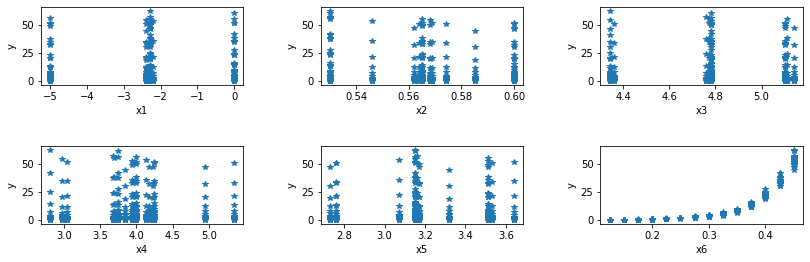

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.tight_layout(rect=[0.1, 0.1, 2, 1], h_pad=4, w_pad=4)

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.plot(Dataxy[:,i], Dataxy[:,-1], '*')
  plt.xlabel('x'+str(i+1))
  plt.ylabel('y')

In [23]:
print(Dataxy[:,:-1].shape)
print(Dataxy[:,-1].shape)


(308, 6)
(308,)


In [24]:
# Separate data

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = \
    train_test_split(Dataxy[:,:-1], Dataxy[:,-1].reshape((-1,1)), test_size=0.3, random_state=21)

In [25]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(215, 6)
(93, 6)
(215, 1)
(93, 1)


In [26]:
np.mean(X_train, axis=0)

array([-2.39906977,  0.56371163,  4.78548837,  3.93576744,  3.20483721,
        0.28860465])

In [27]:
np.var(X_train, axis=0)

array([2.10781309e+00, 5.32381958e-04, 6.61001103e-02, 3.31782551e-01,
       6.00947409e-02, 1.03875879e-02])

In [28]:
mu = np.mean(X_train)
sigma = np.sqrt(np.var(X_train))

xn_train = (X_train - mu)/sigma

print(np.mean(xn_train, axis=0))
print(np.var(xn_train, axis=0))

[-1.61044516 -0.45485215  1.19179505  0.86037284  0.57528334 -0.56215392]
[3.20658451e-01 8.09904705e-05 1.00557109e-02 5.04735829e-02
 9.14212301e-03 1.58024820e-03]


In [29]:
# Normalize input

mu = np.mean(X_train, axis=0)
sigma = np.sqrt(np.var(X_train, axis=0))

xn_train = (X_train - mu)/sigma

In [30]:
print(mu)
print(sigma)

[-2.39906977  0.56371163  4.78548837  3.93576744  3.20483721  0.28860465]
[1.45183094 0.0230734  0.25709942 0.57600569 0.24514229 0.10191952]


In [31]:
print(np.mean(xn_train, axis=0))

[ 1.46923817e-15  3.92058479e-14  2.15256108e-14 -8.79167540e-15
  2.12796189e-14  8.97473310e-16]


In [32]:
print(np.var(xn_train, axis=0))

[1. 1. 1. 1. 1. 1.]


(215, 6)


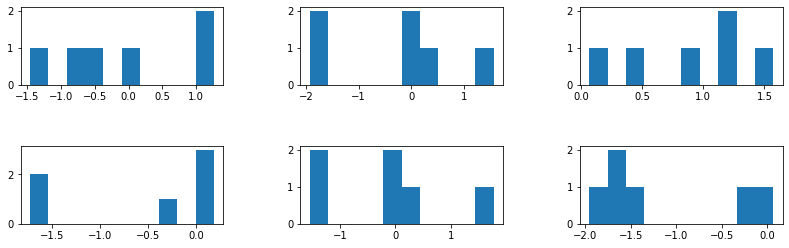

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.tight_layout(rect=[0.1, 0.1, 2, 1], h_pad=4, w_pad=4)

print(xn_train.shape)

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.hist(xn_train[i])

Time spent: 7.2850871086120605
Training
MSE =  0.007517594482805383
RMSE =  0.0867040626660907
Testing
MSE =  0.4769821144069382
RMSE =  0.6906389175299479
r2 = 0.9980146967739666


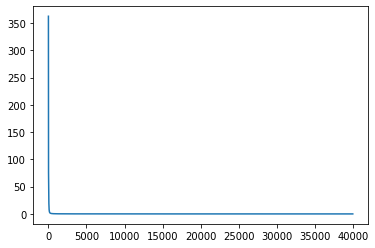

In [34]:
N, D = X_train.shape
_, K = Y_train.shape
M = 32 # number of HUs (hyper-parameter)

# Biases and weights (parameters)
c = np.random.normal(0, 1, K).reshape((K,1))
v = np.random.normal(0, 1, K*M).reshape((K,M))
b = np.random.normal(0, 1, M).reshape((M,1))
w = np.random.normal(0, 1, M*D).reshape((M,D))

lr1 = 0.1/N
lr2 = 0.1/N

t1 = time.time()

cc, vv, bb, ww, train_loss = train_mlp2(c, v, b, w, xn_train, Y_train, lr1, lr2,
                                        40000, identity, mse_loss)
plt.plot(train_loss)

t2 = time.time()

print('Time spent:', t2 - t1)

Yp = mlp2(cc, vv, bb, ww, xn_train, identity)
print('Training')
print('MSE = ', mse_loss(xn_train, Y_train, Yp))
print('RMSE = ', np.sqrt(mse_loss(xn_train, Y_train, Yp)))

# Normalize the test input
xn_test = (X_test - mu)/sigma

Yp = mlp2(cc, vv, bb, ww, xn_test, identity)
print('Testing')
print('MSE = ', mse_loss(xn_test, Y_test, Yp))
print('RMSE = ', np.sqrt(mse_loss(xn_test, Y_test, Yp)))

# R Square
r2 = 1- np.sum( np.square(Yp - Y_test) )/np.sum( np.square( np.mean(Y_test) - Y_test) )
print('r2 =', r2)

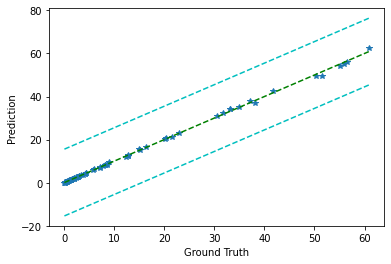

In [ ]:
gtbar = np.mean(Y_test)
gtsigma = np.sqrt(np.var(Y_test))

pmin = np.min(Y_test)
pmax = np.max(Y_test)
plt.plot(Y_test, Yp, '*')
plt.xlabel('Ground Truth')
plt.ylabel('Prediction')
plt.plot([pmin, pmax], [pmin, pmax], "g--")
#plt.plot([pmin, pmax], [gtbar, gtbar], "g:")
plt.plot([pmin, pmax], [pmin+gtsigma, pmax+gtsigma], "c--")
plt.plot([pmin, pmax], [pmin-gtsigma, pmax-gtsigma], "c--")


In [ ]:
np.median(Dataxy[:,5])

0.2875

### Question

If my yacht---supposed I have one, but I don't--- has
1. Longitudinal position of the center of buoyancy **-2.3**,
2. Prismatic coefficient **0.565**,
3. Length-displacement ratio **4.78**,
4. Beam-draught ratio **3.955**, 
5. Length-beam ratio **3.15**, and
6. Froude number **0.2875**,

then what is my boat Residuary resistance?

Another word, how can we use the obtained model to compute?

In [35]:
myboat = np.array( [-2.3, 0.565, 4.78, 3.955, 3.15, 0.2875] ).reshape((1,-1))
myboat.shape

(1, 6)

In [36]:
myboat_RR = mlp2(cc, vv, bb, ww, myboat, identity)
print('Residuary resistance =', myboat_RR)

Residuary resistance = [[8.97205408]]


Is that correct?

Have we normalized the input?

In [ ]:
print(mu)
print(sigma)

[-2.39906977  0.56371163  4.78548837  3.93576744  3.20483721  0.28860465]
[1.45183094 0.0230734  0.25709942 0.57600569 0.24514229 0.10191952]


In [37]:
# Normalize the test input
norm_myboat = (myboat - mu)/sigma

myboat_RR = mlp2(cc, vv, bb, ww, norm_myboat, identity)
print('Residuary resistance =', myboat_RR)

Residuary resistance = [[2.79600888]]


That's more like it.

## Mammographic Mass

http://archive.ics.uci.edu/ml/datasets/mammographic+mass

In [38]:
# Mammographic Mass

print(mypath)

./drive/MyDrive/Y2021/ANN/w13App/data/


In [39]:
!ls ./drive/MyDrive/Y2021/ANN/w13App/data/

mammographic_masses.data  yacht_hydrodynamics.data


In [40]:
with open(mypath + 'mammographic_masses.data', 'r') as f:
    mammo_text = f.read()
    
mammo1 = []            # regular (complete) examples
mammo_miss = []        # missing-data examples
for line in mammo_text.split('\n'):
    row = []
    complete = True
    for field in line.split(','):
        try:
            val = int(field)
        except:
            complete = False
            val = None
        row.append(val)
    if complete:
        mammo1.append(row)
    else:
        mammo_miss.append(row)
# end for line
mammo1 = np.array(mammo1)

In [41]:
mammo1.shape

(830, 6)

In [42]:
len(mammo_miss)

132

In [ ]:
#mammo_miss

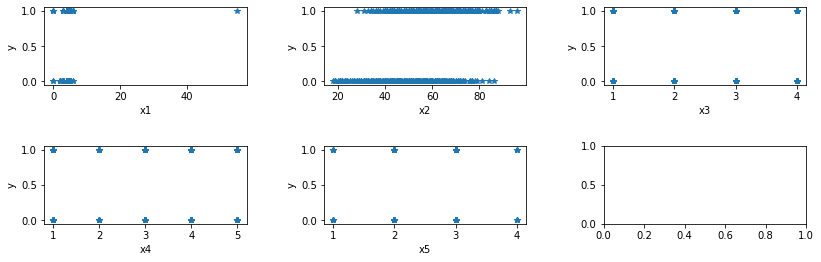

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.tight_layout(rect=[0.1, 0.1, 2, 1], h_pad=4, w_pad=4)

for i in range(5):
  plt.subplot(2,3,i+1)
  plt.plot(mammo1[:,i], mammo1[:,-1], '*')
  plt.xlabel('x'+str(i+1))
  plt.ylabel('y')

Data might not be clean.
So clean it.

In [44]:
max_id = np.argmax(mammo1[:,0])
print(mammo1[max_id,:])

[55 46  4  3  3  1]


This might be typo. We need to fix this.

Here to make it simple, I'll just assume that it is 5 and I'll fix it so.

In [47]:
mammo1[max_id,0] = 5
print(mammo1[max_id,:])

[ 5 46  4  3  3  1]


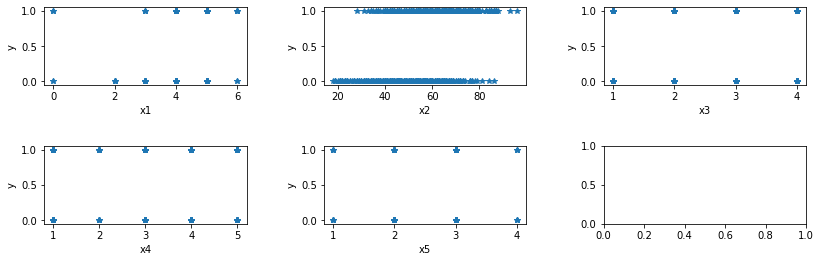

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.tight_layout(rect=[0.1, 0.1, 2, 1], h_pad=4, w_pad=4)

for i in range(5):
  plt.subplot(2,3,i+1)
  plt.plot(mammo1[:,i], mammo1[:,-1], '*')
  plt.xlabel('x'+str(i+1))
  plt.ylabel('y')

BIRADS should not go over 5!

But, I'll let the 6 go for simplicity.
We can fix it to 5, but nah I'll go for the easier this time.

### Handling missing data

There are many approaches we can deal with missing data.

*   Discard them. (Easiest and justified if we have plenty)
*   Fill in with estimate (multiple sub-approaches)
*   Exploit a characteristics of model to handle missing data (c.f. collaborative filtering)

Here we will take the easiest one first.



In [57]:
# Separate data

from sklearn.model_selection import train_test_split

Y = mammo1[:,-1].reshape((-1,1))

X_train, X_test, Y_train, Y_test = \
    train_test_split(mammo1[:,:-1], Y, stratify=Y, test_size=0.3, random_state=21)

In [58]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(581, 5)
(249, 5)
(581, 1)
(249, 1)


Why do we need to ```stratify=Y```?

In [59]:
print('Train positive ratio = ', np.sum(mammo1[:,-1] == 1)/mammo1.shape[0] )
print('Test positive ratio = ', np.sum(mammo1[:,-1] == 1)/mammo1.shape[0])

Train positive ratio =  0.4855421686746988
Test positive ratio =  0.4855421686746988


In [60]:
print('Train positive ratio = ', np.sum(Y_train == 1)/Y_train.shape[0] )
print('Test positive ratio = ', np.sum(Y_test == 1)/Y_test.shape[0])

Train positive ratio =  0.4853700516351119
Test positive ratio =  0.4859437751004016


Now let's see if we don't do ```stratify```.

You can always read the document.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

But I think it's nice to learn by doing.

(array([292.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 289.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

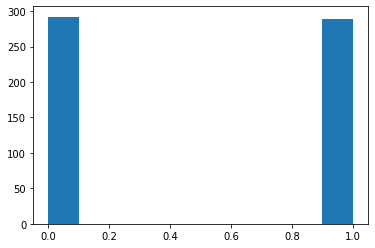

In [61]:
X2_train, X2_test, Y2_train, Y2_test = \
    train_test_split(mammo1[:,:-1], Y, test_size=0.3, random_state=21)

plt.hist(Y2_train)    

In [62]:
print('Train positive ratio = ', np.sum(Y2_train == 1)/Y2_train.shape[0] )
print('Test positive ratio = ', np.sum(Y2_test == 1)/Y2_test.shape[0])

Train positive ratio =  0.4974182444061962
Test positive ratio =  0.4578313253012048


In our case, the data is pretty balanced. So it is not a big deal whether we do ```stratify``` or not.

But for badly unbalanced data, we need to pay more attention to this.

### Coding input

Notice that most input dimensions are not really numerical. They are actually categorical.

*   Dimension 1 (BI-RADS assessment) is ordinal, treating it as a number should not be too far off.
*   Dimension 2 (Age) is integer. This one is naturally numeric.
*   Dimension 5 are (Density) is also ordinal. ---I'll assume that it is OK with numeric.
*   Dimensions 3 and 4 are nominal. These are not numeric in nature, e.g., shape 1 is not more similar to shape 2 than shape 4 is.

#### Approach 1: all as numeric (let's see how it goes)

In [63]:
# Normalize input

mu = np.mean(X_train, axis=0)
sigma = np.sqrt(np.var(X_train, axis=0))

xn_train = (X_train - mu)/sigma


In [64]:
X_train.shape

(581, 5)

In [65]:
print(mu)
print(sigma)

[ 4.31497418 56.09122203  2.80378657  2.84337349  2.9070568 ]
[ 0.72020236 14.58196403  1.22624181  1.5758215   0.35441903]


Time spent: 0.07720828056335449


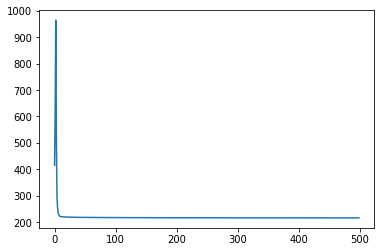

In [66]:
# Choose hyper-parameter, then initialize and train the network.
N, D = X_train.shape
_, K = Y_train.shape
M = 2 # number of HUs (hyper-parameter), 
       #        M = 10, test acc = 0.8353 
       #                for both norm and coding when do early stopping.
       #        I could reach test acc 0.839 for using only M=2 (lr=10/N, epoch=4000)

# Biases and weights (parameters)
c = np.random.normal(0, 1, K).reshape((K,1))
v = np.random.normal(0, 1, K*M).reshape((K,M))
b = np.random.normal(0, 1, M).reshape((M,1))
w = np.random.normal(0, 1, M*D).reshape((M,D))

lr1 = 10/N
lr2 = 10/N

t1 = time.time()

cc, vv, bb, ww, train_loss = train_mlp2(c, v, b, w, xn_train, Y_train, lr1, lr2,
                                        500, sigmoid, cross_entropy)
plt.plot(train_loss)

t2 = time.time()

print('Time spent:', t2 - t1)

In [67]:
cutoff = 0.5

Yp = mlp2(cc, vv, bb, ww, xn_train, sigmoid)
Ybin = Yp > cutoff
print('Training')
print('Accuracy = ', np.sum(Ybin == Y_train)/N)


Training
Accuracy =  0.8433734939759037


In [68]:
## Evaluate the network

# Normalize the test input
xn_test = (X_test - mu)/sigma

Yp = mlp2(cc, vv, bb, ww, xn_test, sigmoid)
Ybin = Yp > cutoff
print('Test')
print('Accuracy = ', np.mean(Ybin == Y_test))

Test
Accuracy =  0.8393574297188755


##### Early stopping

To do early stopping, we separate our **training set** into a real training set and a validation set.

In [ ]:
X_rtrain, X_val, Y_rtrain, Y_val = \
    train_test_split(X_train, Y_train, stratify=Y_train, test_size=0.1, random_state=21)

In [ ]:
print(X_rtrain.shape)
print(Y_rtrain.shape)
print(X_val.shape)
print(Y_val.shape)

(522, 5)
(522, 1)
(59, 5)
(59, 1)


In [ ]:
# Normalized input
mu = np.mean(X_train, axis=0)
sigma = np.sqrt(np.var(X_train, axis=0))

xn_rtrain = (X_rtrain - mu)/sigma
xn_val = (X_val - mu)/sigma


0 * val loss= 96.73348498984001
1 * val loss= 87.07937069222733
2 * val loss= 62.95343583336548
3 * val loss= 58.5057220670588
4 * val loss= 38.522569132948824
5 * val loss= 34.281549384286066
6 * val loss= 31.89485744794064
7 * val loss= 30.78755559444515
8 * val loss= 30.165041275077023
9 * val loss= 29.707233181503817
10 * val loss= 29.484007499324566
11 * val loss= 29.26890394390545
12 * val loss= 29.179717827677127
13 * val loss= 29.07201648656089
14 * val loss= 29.04319494368022
15 * val loss= 29.001216189070213
16 * val loss= 29.00609951596327
17 * val loss= 28.999682752467823
18 * val loss= 29.01376832262459
19 * val loss= 29.01629359073104
20 * val loss= 29.026302030817675
Early stopping criteria is met at 20
Time spent: 0.05911707878112793


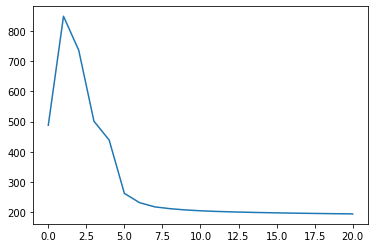

In [ ]:
# Choose hyper-parameter, then initialize and train the network.
N, D = X_rtrain.shape
_, K = Y_train.shape
M = 2 # number of HUs (hyper-parameter)

# Biases and weights (parameters)
c = np.random.normal(0, 1, K).reshape((K,1))
v = np.random.normal(0, 1, K*M).reshape((K,M))
b = np.random.normal(0, 1, M).reshape((M,1))
w = np.random.normal(0, 1, M*D).reshape((M,D))

lr1 = 10/N
lr2 = 10/N

t1 = time.time()

cc, vv, bb, ww, train_loss = train_mlp2(c, v, b, w, xn_rtrain, Y_rtrain, lr1, lr2,
                                        500, sigmoid, cross_entropy, 
                                        val=(xn_val, Y_val), val_criteria=3)
plt.plot(train_loss)

t2 = time.time()

print('Time spent:', t2 - t1)

In [ ]:
cutoff = 0.5

Yp = mlp2(cc, vv, bb, ww, xn_train, sigmoid)
Ybin = Yp > cutoff
print('Training')
print('Accuracy = ', np.sum(Ybin == Y_train)/N)


Training
Accuracy =  0.9310344827586207


In [ ]:
## Evaluate the network

# Normalize the test input
xn_test = (X_test - mu)/sigma

Yp = mlp2(cc, vv, bb, ww, xn_test, sigmoid)
Ybin = Yp > cutoff
print('Test')
print('Accuracy = ', np.mean(Ybin == Y_test))

Test
Accuracy =  0.8273092369477911


#### Approach 2: dimensions 3 and 4 will be coded.

*   Dimensions 1, 2, and 5 (BI-RADS assessment, Age, Density) as numeric.
*   Dimensions 3 and 4 are nominal. 

In [ ]:
# Prepare input

def mammo_code(xin, params=None):
  '''
  xc, *params = mammo_code(xin)
  xc = mammo_code(xin, params)
  '''

  N, D = xin.shape

  ## Dim 1, 2, 5 needs normalization
  norm_ids = (0, 1, 4)

  if params is None:
    mu = np.zeros((len(norm_ids),))
    sigma = np.zeros((len(norm_ids),))
  else:
    mu, sigma = params

  xnorm = np.zeros( (N,len(norm_ids)) )

  for i in range(len(norm_ids)):
    if params is None:
      mu[i] = np.mean(xin[:, norm_ids[i]])
      sigma[i] = np.sqrt(np.var(xin[:, norm_ids[i]]))

    xnorm[:,i] = (xin[:, norm_ids[i]] - mu[i])/sigma[i]
  # end for i

  ## Dim 3 and 4 needs one-hot coding
  ### Make it easier by turning (1,2,3,4) to (0,1,2,3)
  xdim3 = onehot(xin[:,2].reshape((-1,1)) - 1, (0,1,2,3)) 

  ### Make it easier by turning (1,2,3,4,5) to (0,1,2,3,4)
  xdim4 = onehot(xin[:,3].reshape((-1,1)) - 1, (0,1,2,3,4))

  xout = np.c_[xnorm[:,:2], xdim3, xdim4, xnorm[:,2]]

  if params is None:
    return xout, mu, sigma

  return xout


In [ ]:
# Test

xc_train, *normpar = mammo_code(X_train)
xc_test = mammo_code(X_test, normpar)
print(normpar)
print(xc_train.shape)
print(xc_test.shape)

[array([ 4.31497418, 56.09122203,  2.9070568 ]), array([ 0.72020236, 14.58196403,  0.35441903])]
(581, 12)
(249, 12)


In [ ]:
i = 570
print(X_train[i,:])
print(xc_train[i,:])


[ 5 86  4  4  3]
[0.95115742 2.05108022 0.         0.         0.         1.
 0.         0.         0.         1.         0.         0.262241  ]


In [ ]:
i = np.where(X_test[:,1] == 86)[0][0]
print(X_test[i,:])
print(xc_test[i,:])


[ 5 86  3  4  3]
[0.95115742 2.05108022 0.         0.         1.         0.
 0.         0.         0.         1.         0.         0.262241  ]


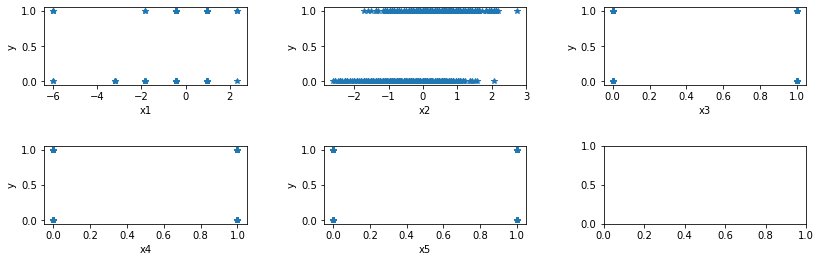

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.tight_layout(rect=[0.1, 0.1, 2, 1], h_pad=4, w_pad=4)

for i in range(5):
  plt.subplot(2,3,i+1)
  plt.plot(xc_train[:,i], Y_train[:,-1], '*')
  plt.xlabel('x'+str(i+1))
  plt.ylabel('y')

Time spent: 0.10622429847717285


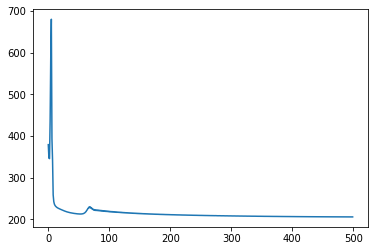

In [ ]:
# Choose hyper-parameter, then initialize and train the network.
N, D = xc_train.shape
_, K = Y_train.shape
M = 2 # number of HUs (hyper-parameter)

# Biases and weights (parameters)
c = np.random.normal(0, 1, K).reshape((K,1))
v = np.random.normal(0, 1, K*M).reshape((K,M))
b = np.random.normal(0, 1, M).reshape((M,1))
w = np.random.normal(0, 1, M*D).reshape((M,D))

lr1 = 10/N
lr2 = 10/N

t1 = time.time()

cc, vv, bb, ww, train_loss = train_mlp2(c, v, b, w, xc_train, Y_train, lr1, lr2,
                                        500, sigmoid, cross_entropy)
plt.plot(train_loss)

t2 = time.time()

print('Time spent:', t2 - t1)

In [ ]:
cutoff = 0.5

Yp = mlp2(cc, vv, bb, ww, xc_train, sigmoid)
Ybin = Yp > cutoff
print('Training')
print('Accuracy = ', np.sum(Ybin == Y_train)/N)


Training
Accuracy =  0.8502581755593803


In [ ]:
## Evaluate the network

# Code the test input
xc_test = mammo_code(X_test, normpar)

Yp = mlp2(cc, vv, bb, ww, xc_test, sigmoid)
Ybin = Yp > cutoff
print('Test')
print('Accuracy = ', np.mean(Ybin == Y_test))

Test
Accuracy =  0.8273092369477911


##### Early stopping

In [ ]:
xc_rtrain, *normpar = mammo_code(X_rtrain)  
# I could find normpar from the combination of rtrain and val, 
# but I'll do it simply here.

# Code the val input
xc_val = mammo_code(X_val, normpar)


print(normpar)
print(xc_rtrain.shape)
print(xc_val.shape)

[array([ 4.31992337, 55.97318008,  2.90613027]), array([ 0.74480679, 14.60368036,  0.35124405])]
(522, 12)
(59, 12)


0 * val loss= 62.813465350384384
1 * val loss= 65.76164452739518
2 * val loss= 61.41640870608512
3 * val loss= 64.27408325851317
4 * val loss= 60.58413995389589
5 * val loss= 62.91785084086838
6 * val loss= 59.884347238798014
7 * val loss= 61.73501949397221
8 * val loss= 59.12794700520833
9 * val loss= 59.852347299450024
10 * val loss= 54.03578632720573
11 * val loss= 50.79474666110314
12 * val loss= 37.928072243161694
13 * val loss= 37.30862941074569
14 * val loss= 29.063263185668973
15 * val loss= 30.96820705729987
16 * val loss= 28.300420659132417
17 * val loss= 29.346588445480712
18 * val loss= 28.226456439405936
19 * val loss= 28.635095718968856
20 * val loss= 28.041685950580025
21 * val loss= 28.181566612828668
22 * val loss= 27.824360107147527
23 * val loss= 27.853306007829072
24 * val loss= 27.61751450747942
25 * val loss= 27.60123433013765
26 * val loss= 27.434895236158077
27 * val loss= 27.402263865059147
28 * val loss= 27.280004571520394
29 * val loss= 27.244579652295712
30 

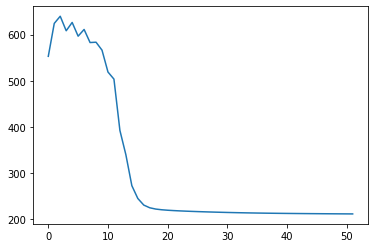

In [ ]:
# Choose hyper-parameter, then initialize and train the network.
N, D = xc_train.shape
_, K = Y_train.shape
M = 2 # number of HUs (hyper-parameter)

# Biases and weights (parameters)
c = np.random.normal(0, 1, K).reshape((K,1))
v = np.random.normal(0, 1, K*M).reshape((K,M))
b = np.random.normal(0, 1, M).reshape((M,1))
w = np.random.normal(0, 1, M*D).reshape((M,D))

lr1 = 10/N
lr2 = 10/N

t1 = time.time()

cc, vv, bb, ww, train_loss = train_mlp2(c, v, b, w, xc_train, Y_train, lr1, lr2,
                                        500, sigmoid, cross_entropy, 
                                        val=(xc_val, Y_val), val_criteria=3)
plt.plot(train_loss)

t2 = time.time()

print('Time spent:', t2 - t1)

In [ ]:
cutoff = 0.5

Yp = mlp2(cc, vv, bb, ww, xc_train, sigmoid)
Ybin = Yp > cutoff
print('Training')
print('Accuracy = ', np.sum(Ybin == Y_train)/N)


Training
Accuracy =  0.8554216867469879


In [ ]:
## Evaluate the network

# Code the test input
xc_test = mammo_code(X_test, normpar)

Yp = mlp2(cc, vv, bb, ww, xc_test, sigmoid)
Ybin = Yp > cutoff
print('Test')
print('Accuracy = ', np.mean(Ybin == Y_test))

Test
Accuracy =  0.8433734939759037



### Confusion matrix and f-score

Usually, positive is a minority class.

In [ ]:
print(np.sum(Y_test==1))
print(np.sum(Y_test==0))

121
128


In [ ]:
TP = np.sum( (Ybin == 1)*(Y_test == 1) )
FP = np.sum( (Ybin == 1)*(Y_test == 0) )
FN = np.sum( (Ybin == 0)*(Y_test == 1) )
TN = np.sum( (Ybin == 0)*(Y_test == 0) )

print('    \t|y={0: <10}  \t|y={1: <10} \t|'.format(1, 0))
print('-----------------------------------------')
print('yp=1\t|TP={0: <8} \t|FP={1: <8}\t|'.format(TP, FP))
print('yp=0\t|FN={0: <8} \t|TN={1: <8}\t|'.format(FN, TN))

    	|y=1           	|y=0          	|
-----------------------------------------
yp=1	|TP=93       	|FP=15      	|
yp=0	|FN=28       	|TN=113     	|


In [ ]:
P = TP/(TP + FP)
R = TP/(TP + FN)
F = 2*P*R/(P +R)

print('Precision, P =', P)
print('Recall, R =', R)
print('F-score =', F)


Precision, P = 0.8611111111111112
Recall, R = 0.768595041322314
F-score = 0.8122270742358079


### P-R Curve

In [ ]:
sorted_Yp = np.sort(Yp,axis=0)

Fmax = 0
tau_max = 0
Pfm = 0
Rfm = 0

eps= 1e-3

Ps = []
Rs = []

for i, tau in enumerate(sorted_Yp[:-1]):
  Ybin = (Yp > tau)

  TP = np.sum( (Ybin == 1)*(Y_test == 1) , axis=0)
  FP = np.sum( (Ybin == 1)*(Y_test == 0) , axis=0 )
  FN = np.sum( (Ybin == 0)*(Y_test == 1) , axis=0 )

  P = TP / (TP + FP + eps)
  R = TP / (TP + FN + eps)
  F = 2*P*R/(P +R)

  Ps.append(P)
  Rs.append(R)

  if F > Fmax:
    Fmax = F
    tau_max = tau
    Pfm = P
    Rfm = R


  if i > 247:
    break
# end for

print('F max: {} at tau = {}'.format(Fmax, tau_max))


F max: [0.84080946] at tau = [0.4974755]


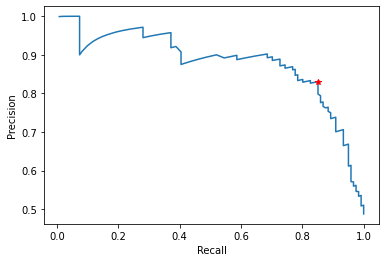

In [ ]:
plt.plot(Rs, Ps)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(Rfm, Pfm, 'r*')

### Bayesian Probability

p(y=1|yp=1) represents a probability that the test result indicates malignant yp=1 when it is really malignant y=1.

*   Supposed 17% of women over 40 actually have breast cancers. That is, p(y=1) = 0.17.

*   Probability p(yp=1|y=1) is approximately recall, e.g., 0.85.

*   Probability p(yp=1|y=0) is approximately FP/(FP + TN), e.g., 21/(21+107) = 0.16.

Therefore

In [ ]:
printmd(r'$$ p(y=1| \hat{y}=1) = \frac{ p(\hat{y}=1|y=1) \cdot p(y=1) }{ p(\hat{y}=1|y=0) \cdot p(y=0) + p(\hat{y}=1|y=1) \cdot p(y=1)} $$')

$$ p(y=1| \hat{y}=1) = \frac{ p(\hat{y}=1|y=1) \cdot p(y=1) }{ p(\hat{y}=1|y=0) \cdot p(y=0) + p(\hat{y}=1|y=1) \cdot p(y=1)} $$

In [ ]:
Ybin = Yp > cutoff

TP = np.sum( (Ybin == 1)*(Y_test == 1) )
FP = np.sum( (Ybin == 1)*(Y_test == 0) )
FN = np.sum( (Ybin == 0)*(Y_test == 1) )
TN = np.sum( (Ybin == 0)*(Y_test == 0) )

R = TP/(TP + FN)

print('p(y=1 | yp=1) =', R*0.17/(FP/(FP + TN)*(1 - 0.17) + R*0.17 ))


p(y=1 | yp=1) = 0.5152000662021788


That's why mammography is only a preliminary screening
and the confirmation requires a (painful) biopsy.

Discussion on **Handling Unbalanced Data**

Common approaches: oversampling minority, undersampling majority, emphasizing loss on the minority through masking majority or penalizing minority, bayesian statistics, etc.

In [ ]:
pos = 10000
N = 7000000000

In [ ]:
pos/N

1.4285714285714286e-06

In [ ]:
pos/N * 700000000

1000.0

## MNIST

http://yann.lecun.com/exdb/mnist/

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import time

Old school loading MNIST is pretty low level.
For example,

*   it starts with unzip the gz file, e.g., ```gzip -d t10k-images-idx3-ubyte.gz```. 
*   Then, read binary file, cross-check, and put data in place.

For example,
```
import struct
with open(mypath + '/train-labels-idx1-ubyte','rb') as f:
    # Read header
    for i in range(2):
        try:
            bi = f.read(4)
            print('bi:', bi)
            print('* little endian:', struct.unpack_from("<I",bi)[0])
            print('* big endian:', struct.unpack_from(">I",bi)[0])
        except struct.error:
            print('error')

    trainy = []
    for i in range(60000):
        try:
            bi = f.read(1)
            trainy.append(struct.unpack_from(">B",bi)[0])
        except struct.error:
            print('error')
    trainy = np.array(trainy).reshape((-1,1))
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/2021/ANN/w14AnnMoreEx


ANN_auxw14.py  code_ann_Ex_mnist5.ipynb  t10k-labels-idx1-ubyte
annlib.py      __pycache__		 train-images-idx3-ubyte
ANN_w14.py     t10k-images-idx3-ubyte	 train-labels-idx1-ubyte


In [ ]:
!more drive/MyDrive/2021/ANN/w14AnnMoreEx/t10k-labels-idx1-ubyte

						
			
					


Scikit-learn has provided a convenient access.

In [ ]:
from sklearn.datasets import fetch_openml

In [ ]:
t1 = time.time()

X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

t2 = time.time()

print('Loading time', t2-t1)

Loading time 33.36121702194214


In [ ]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [ ]:
y[0]

'5'

In [ ]:
X[0,:]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

The original MNIST provides separated sets of training and test, but sklearn has them togeter.

Therefore, we need to separate data.

In [ ]:
# Separate data

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = \
    train_test_split(X, y, stratify=y, test_size=0.14, random_state=21)

### Explore data

It is a good practice to explore the data.

In [ ]:
28*28

784

In [ ]:
print(X_train.shape)
print(X_train[0,:])

print(Y_train.shape)
print(Y_train[0])
print(type(Y_train[0]))

(60199, 784)
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   5. 123.
 133.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  98. 253.
 253.  70.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 172. 253.
 236.  46.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  14. 147. 242. 232.
  49.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  73. 253. 253. 144.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0

Text(0.5, 1.0, '5')

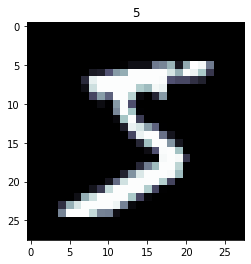

In [ ]:
i = 0
plt.imshow(X[i,:].reshape((28,28)), cmap=plt.cm.bone)
plt.title('{}'.format(y[i]))

Text(0.5, 1.0, '7')

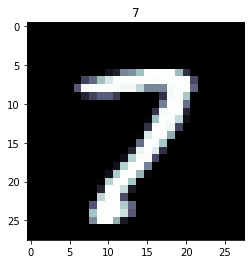

In [ ]:
i = 5000
plt.imshow(X_train[i,:].reshape((28,28)), cmap=plt.cm.bone)
plt.title('{}'.format(Y_train[i]))

In [ ]:
Y_train[0]

'6'

In [ ]:
np.unique(Y_train)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls ./drive/MyDrive/2021/ANN/w14AnnMoreEx

ANN_auxw14.py  code_ann_Ex_mnist5.ipynb  t10k-labels-idx1-ubyte
annlib.py      __pycache__		 train-images-idx3-ubyte
ANN_w14.py     t10k-images-idx3-ubyte	 train-labels-idx1-ubyte


In [ ]:
import sys
sys.path.append("./drive/MyDrive/2021/ANN/w14AnnMoreEx") # my path


In [ ]:
from ANN_w14 import *

### Prepare onehot output

In [ ]:
Yc_train = onehot(Y_train.reshape((-1,1)).astype(np.int))
print(Y_train[:5])
print(Yc_train[:5,:])

['6' '6' '3' '9' '0']
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### Normalize input

In [ ]:
print(np.min(X_train))
print(np.max(X_train))

0.0
255.0


In [ ]:
Xn_train = X_train/255

print(np.min(Xn_train))
print(np.max(Xn_train))

0.0
1.0


### Re-examine data

Text(0.5, 1.0, 'y = 5')

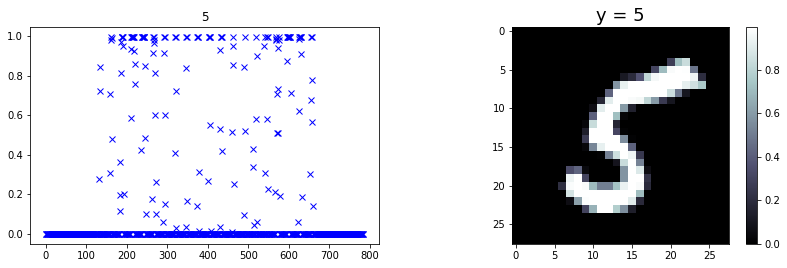

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.tight_layout(rect=[0.1, 0.1, 2, 1], h_pad=6, w_pad=4)

i = 7
plt.subplot(1,2,1)
plt.plot(Xn_train[i,:], 'bx')
plt.title('{}'.format(Y_train[i]))

plt.subplot(1,2,2)
s = plt.imshow(Xn_train[i,:].reshape((28,28)), cmap=plt.cm.bone)
plt.colorbar(s)
plt.title('y = {}'.format(Y_train[i]), fontsize=18)

### Prepare model

Try 8 HUs with lr = 1 and #epochs = 100

Time spent: 46.71801447868347


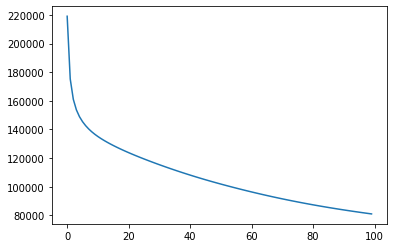

In [ ]:
# Choose hyper-parameter, then initialize and train the network.
N, D = Xn_train.shape
_, K = Yc_train.shape
M = 8 # number of HUs (hyper-parameter), 

# Biases and weights (parameters)
c = np.random.normal(0, 1, K).reshape((K,1))
v = np.random.normal(0, 1, K*M).reshape((K,M))
b = np.random.normal(0, 1, M).reshape((M,1))
w = np.random.normal(0, 1, M*D).reshape((M,D))

lr1 = 1/N
lr2 = 1/N

t1 = time.time()

cc, vv, bb, ww, train_loss = train_mlp2(c, v, b, w, Xn_train, Yc_train, lr1, lr2,
                                        100, softmax, cc_entropy)

t2 = time.time()

print('Time spent:', t2 - t1)

plt.plot(train_loss)

In [ ]:
train_loss

[219149.98171669882,
 175280.39950527766,
 161077.0167210553,
 153712.8899654044,
 148965.4465522617,
 145476.18515178468,
 142697.46490020351,
 140380.835558067,
 138393.5333711842,
 136650.1355406449,
 135089.32076776808,
 133666.06129499275,
 132347.83494319237,
 131111.6227006845,
 129941.19944496223,
 128824.94458932233,
 127754.28377592273,
 126722.6795434212,
 125725.00499079679,
 124757.14605472908,
 123815.73106381706,
 122897.93369442533,
 122001.32513869026,
 121123.77021755229,
 120263.37230635404,
 119418.46657189468,
 118587.64552523303,
 117769.79111138366,
 116964.08612696774,
 116169.98334828531,
 115387.13121737236,
 114615.28360717784,
 113854.23108676846,
 113103.7724895702,
 112363.71789718617,
 111633.89968547157,
 110914.17490186094,
 110204.41928924786,
 109504.52398687637,
 108814.40326650976,
 108134.00846014109,
 107463.33260973095,
 106802.39516354285,
 106151.20993911814,
 105509.74773902082,
 104877.90499320015,
 104255.48701965155,
 103642.21042062796,
 1

#### Train further if need

In [ ]:
lr1 = 1/N
lr2 = 1/N

t1 = time.time()

cc, vv, bb, ww, train_loss2 = train_mlp2(cc, vv, bb, ww, Xn_train, Yc_train, lr1, lr2,
                                        200, softmax, cc_entropy)
t2 = time.time()

print('Time spent:', t2 - t1)

Time spent: 90.67317914962769


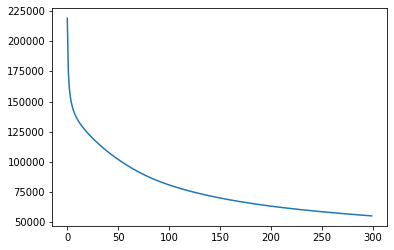

In [ ]:
train_loss.extend(train_loss2)

plt.plot(train_loss)

Time spent: 182.6794717311859


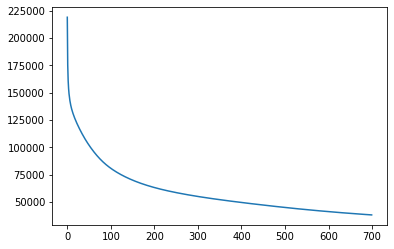

In [ ]:
lr1 = 1/N
lr2 = 1/N

t1 = time.time()

cc, vv, bb, ww, train_loss2 = train_mlp2(c, v, b, w, Xn_train, Yc_train, lr1, lr2,
                                        400, softmax, cc_entropy)
t2 = time.time()

print('Time spent:', t2 - t1)

train_loss.extend(train_loss2)

plt.plot(train_loss)


### Test the trained model

In [ ]:
# Test network

Xn_test  = X_test/255

Yp = mlp2(cc, vv, bb, ww, Xn_test, softmax)
predicted_classes = np.argmax(Yp, axis=1)

In [ ]:
test_acc = np.mean(predicted_classes == Y_test.astype(np.int))
print('Test accuracy', test_acc)

Test accuracy 0.8198143046627895


If you are happy with the model, **SAVE IT!**

**QUESTION!**

What do we actually save when we "save the model"?



(10, 1)
(10, 8)
(8, 1)
(8, 784)


Text(0.5, 1.0, 'w')

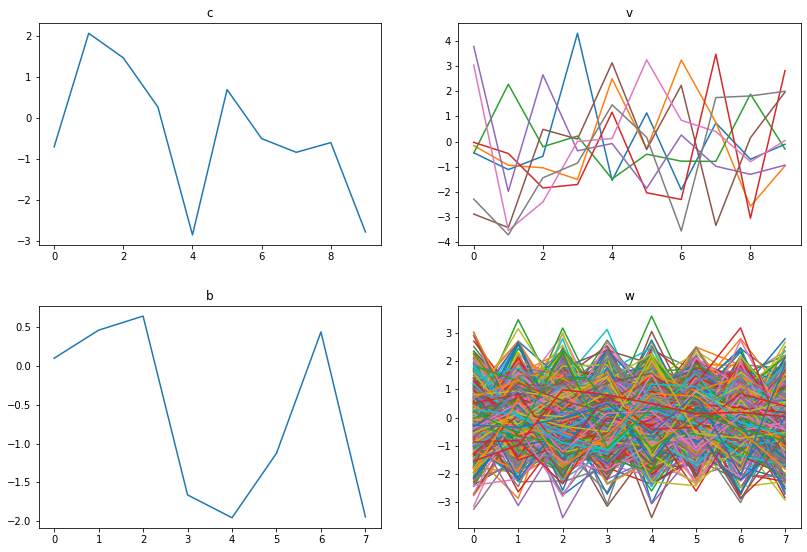

In [ ]:
print(cc.shape)
print(vv.shape)
print(bb.shape)
print(ww.shape)

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.tight_layout(rect=[0.1, 0.1, 2, 2], h_pad=4, w_pad=4)

plt.subplot(2,2,1)
plt.plot(cc)
plt.title('c')

plt.subplot(2,2,2)
plt.plot(vv)
plt.title('v')

plt.subplot(2,2,3)
plt.plot(bb)
plt.title('b')

plt.subplot(2,2,4)
plt.plot(ww)
plt.title('w')

In [ ]:
net = {'c': cc, 'v': vv, 'b': bb, 'w': ww}

np.save('netw14a.npy', net)

In [ ]:
# Test if it can be loaded ok

loaded_net = np.load('netw14a.npy', allow_pickle=True)

In [ ]:
print(type(loaded_net))

<class 'numpy.ndarray'>


In [ ]:
lnet = loaded_net.tolist()
print(type(lnet))
print(lnet['c'])

<class 'dict'>
[[-0.69892182]
 [ 2.07601717]
 [ 1.47561312]
 [ 0.27402478]
 [-2.84998199]
 [ 0.70033195]
 [-0.49670904]
 [-0.83217895]
 [-0.59389775]
 [-2.77780031]]


(10, 1)
(10, 8)
(8, 1)
(8, 784)


Text(0.5, 1.0, 'w')

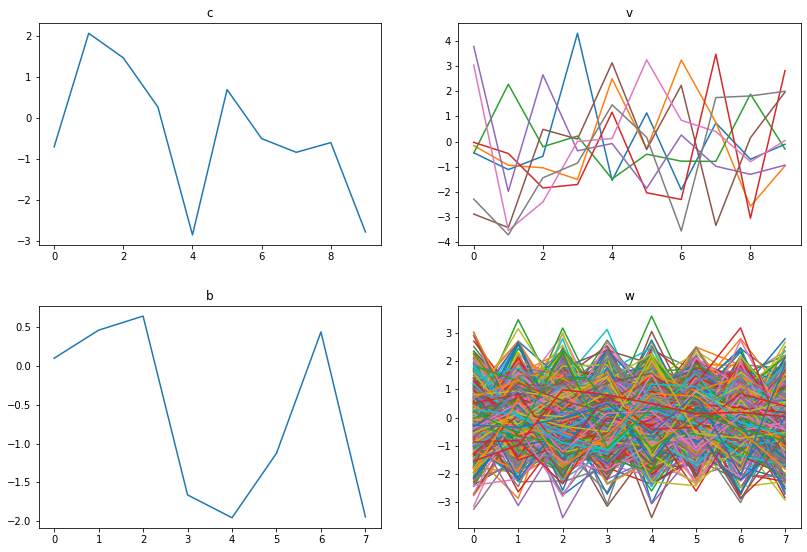

In [ ]:
print(lnet['c'].shape)
print(lnet['v'].shape)
print(lnet['b'].shape)
print(lnet['w'].shape)

fig, axes = plt.subplots(nrows=2, ncols=2)
fig.tight_layout(rect=[0.1, 0.1, 2, 2], h_pad=4, w_pad=4)

plt.subplot(2,2,1)
plt.plot(lnet['c'])
plt.title('c')

plt.subplot(2,2,2)
plt.plot(lnet['v'])
plt.title('v')

plt.subplot(2,2,3)
plt.plot(lnet['b'])
plt.title('b')

plt.subplot(2,2,4)
plt.plot(lnet['w'])
plt.title('w')

In [ ]:
Yp = mlp2(lnet['c'], lnet['v'], lnet['b'], lnet['w'], Xn_test, softmax)
predicted_classes = np.argmax(Yp, axis=1)
test_acc = np.mean(predicted_classes == Y_test.astype(np.int))
print('Test accuracy', test_acc)

Test accuracy 0.8198143046627895


### Confusion matrix

To be cleaned up ...

In [ ]:
cmat = np.zeros((10, 10)) # Pred x G. Truth
cmat

In [ ]:
for r in range(10):
    for c in range(10):
        ids = np.where(testy[0,:] == c)
        count = np.sum(Yc[ids] == r)
        cmat[r, c] = count
        print("%d & "%count, end='')
    print('\\\\')

### Investigate errors

To be cleaned up

In [ ]:
id9F = np.where( (testy[0,:] == 9) * (Yc == 4) )[0]

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4)
fig.tight_layout(rect=[0.1, 0.1, 12, 3], h_pad=2, w_pad=1)

for i, j in enumerate(id9F[:4]):
#     print(i)
    plt.subplot(1,4, 1 + i)
    s = plt.imshow(testxn[:,j].reshape((28,28)), cmap=plt.cm.bone)
# #     plt.colorbar(s)
    plt.title('y[%d] = %d; Predict %d'%(j, testy[:,j], Yc[j]), fontsize=52)
plt.show()

In [ ]:
id4F = np.where( (testy[0,:] == 4) * (Yc == 9) )[0]

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=4)
fig.tight_layout(rect=[0.1, 0.1, 12, 3], h_pad=2, w_pad=1)

for i, j in enumerate(id4F[:4]):
#     print(i)
    plt.subplot(1,4, 1 + i)
    s = plt.imshow(testxn[:,j].reshape((28,28)), cmap=plt.cm.bone)
# #     plt.colorbar(s)
    plt.title('y[%d] = %d; Predict %d'%(j, testy[:,j], Yc[j]), fontsize=52)
plt.show()   

### Discussion

*   Spatial structure
*   Scale, location, orientation invariance
*   What is fundamentally missing?

